In [1]:
! nvidia-smi

Thu Jan 12 21:21:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    31W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
device = 'cuda:0'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import sys
sys.path.append('../..')

In [5]:
import lovely_tensors as lt
lt.monkey_patch()

In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time
from IPython.display import display, clear_output

In [7]:
from pathlib import Path
DATA_DIR = Path('../../data')

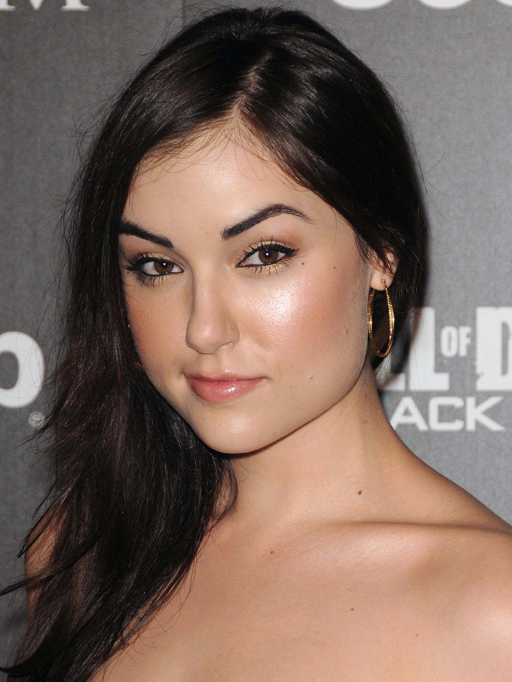

In [8]:
image_pil = Image.open(DATA_DIR/'sasha.jpg')

W, H = image_pil.size
aspect = H/W

W = 512
H = int( W * aspect )
image_pil = image_pil.resize((W,H))

image_pil

In [9]:
image = torch.tensor(np.asarray(image_pil)).permute(2,0,1)/255
H, W = image.shape[1:]
image = image.to(device)
image

tensor[3, 682, 512] n=1047552 x∈[0., 1.000] μ=0.422 σ=0.256 cuda:0

In [10]:
def get_uvs(H, W, device='cpu'):
    xs = torch.linspace(-1, 1, W).to(device)
    ys = torch.linspace(-1, 1, H).to(device)

    x, y = torch.meshgrid(xs, ys, indexing='xy')
    uvs = torch.stack([x,y], dim=-1)
    return uvs

In [11]:
uvs = get_uvs(H, W, device='cpu').to(device)
uvs

tensor[682, 512, 2] n=698368 x∈[-1.000, 1.000] μ=5.593e-09 σ=0.578 cuda:0

/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:4194: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


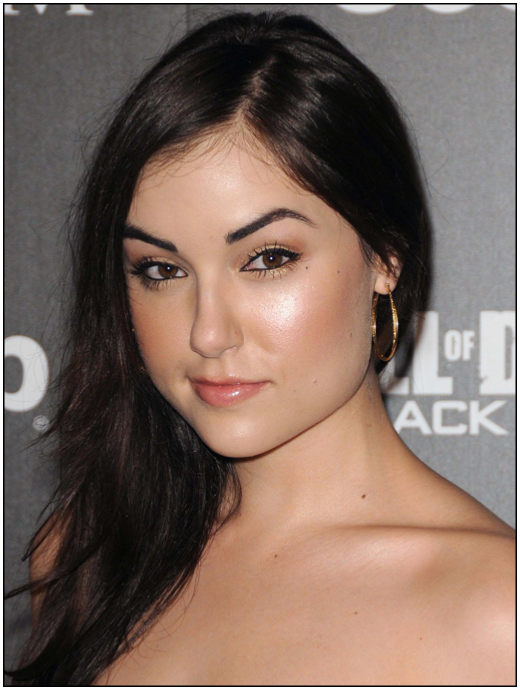

In [12]:
F.grid_sample(image[None], uvs[None]).rgb

In [31]:
def tensor2pil(t): 
    return Image.fromarray((t.detach().permute(1,2,0).clip(0, 1).cpu().numpy() * 255).astype(np.uint8))

# SIREN

In [13]:
try:
    from prettytable import PrettyTable
except:
    ! pip install prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [14]:
from my_neural_fields.nets.siren import Siren

In [15]:
siren = Siren(in_features=2, out_features=3, hidden_features=256, 
                  hidden_layers=4, outermost_linear=True)

count_parameters(siren)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |    512     |
|  net.0.linear.bias  |    256     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    256     |
| net.2.linear.weight |   65536    |
|  net.2.linear.bias  |    256     |
| net.3.linear.weight |   65536    |
|  net.3.linear.bias  |    256     |
| net.4.linear.weight |   65536    |
|  net.4.linear.bias  |    256     |
|     net.5.weight    |    768     |
|      net.5.bias     |     3      |
+---------------------+------------+
Total Trainable Params: 264707


264707

In [16]:
siren.to(device);

In [18]:
steps_til_summary = 20
steps_til_vis = 500
optimizer = torch.optim.Adam(lr=1e-4, params=siren.parameters())

import wandb
wandb.init(project='my-neural-fields', name='siren')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: kilianovski. Use `wandb login --relogin` to force relogin


step_i=480 0.0007


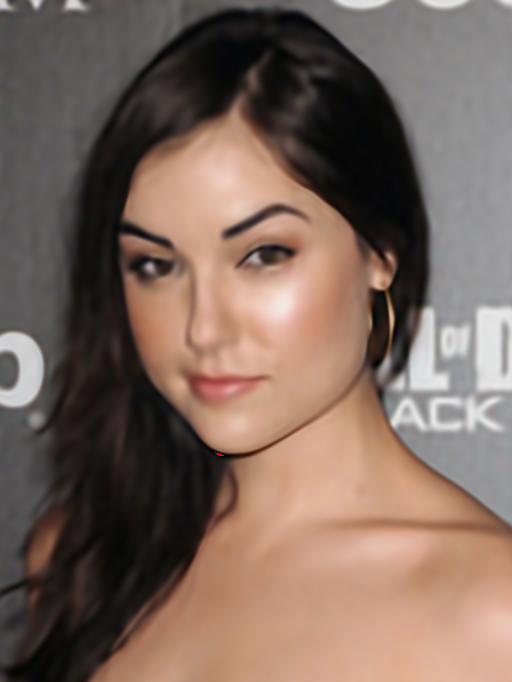

KeyboardInterrupt: 

In [32]:
step_i = 0

while True:
    pred_image, _ = siren(uvs)
    pred_image = pred_image.permute(2,0,1)
    loss = F.mse_loss(pred_image, image)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f}')
        display(pred_image.rgb)
        
    step_i += 1

# uinet 

In [34]:
x = torch.rand(32, 2)

In [67]:


def get_emb(sin_inp):
    """
    Gets a base embedding for one dimension with sin and cos intertwined
    """
    emb = torch.stack((sin_inp.sin(), sin_inp.cos()), dim=-1)
    return torch.flatten(emb, -2, -1)


class PositionalEncoding1D(nn.Module):
    def __init__(self, channels):
        """
        :param channels: The last dimension of the tensor you want to apply pos emb to.
        """
        super(PositionalEncoding1D, self).__init__()
        self.org_channels = channels
        channels = int(np.ceil(channels / 2) * 2)
        self.channels = channels
        inv_freq = 1.0 / (10000 ** (torch.arange(0, channels, 2).float() / channels))
        self.register_buffer("inv_freq", inv_freq)
        self.cached_penc = None

    def forward(self, tensor):
        """
        :param tensor: A 3d tensor of size (batch_size, x, ch)
        :return: Positional Encoding Matrix of size (batch_size, x, ch)
        """
        if len(tensor.shape) != 3:
            raise RuntimeError("The input tensor has to be 3d!")

        if self.cached_penc is not None and self.cached_penc.shape == tensor.shape:
            return self.cached_penc

        self.cached_penc = None
        batch_size, x, orig_ch = tensor.shape
        pos_x = torch.arange(x, device=tensor.device).type(self.inv_freq.type())
        sin_inp_x = torch.einsum("i,j->ij", pos_x, self.inv_freq)
        emb_x = get_emb(sin_inp_x)
        emb = torch.zeros((x, self.channels), device=tensor.device).type(tensor.type())
        emb[:, : self.channels] = emb_x

        self.cached_penc = emb[None, :, :orig_ch].repeat(batch_size, 1, 1)
        return self.cached_penc


In [78]:
# ! pip install random-fourier-features-pytorch
import rff

X = torch.randn((256, 256, 2))
encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=64).to(device)
# Xp = encoding(X)
# Xp

In [79]:
encoding(uvs)

tensor[682, 512, 128] n=44695552 x∈[-1.000, 1.000] μ=-6.307e-05 σ=0.707 cuda:0

In [36]:
h = 32

In [46]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        
    def forward(self, x):
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o

In [63]:
h = 64

In [80]:
uber_inet = nn.Sequential(
    encoding,
    UberLayer(128, h),
    UberLayer(h, h),
    UberLayer(h, h),

    nn.Linear(h, 3)
).to(device)

count_parameters(uber_inet)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| 1.linear.weight |   32768    |
|  1.linear.bias  |    256     |
| 2.linear.weight |   16384    |
|  2.linear.bias  |    256     |
| 3.linear.weight |   16384    |
|  3.linear.bias  |    256     |
|     4.weight    |    192     |
|      4.bias     |     3      |
+-----------------+------------+
Total Trainable Params: 66499


66499

In [81]:
steps_til_summary = 20
steps_til_vis = 500
optimizer = torch.optim.Adam(lr=1e-4, params=uber_inet.parameters())

import wandb
wandb.init(project='my-neural-fields', name='uber_inet_00')

count_parameters(uber_inet)

loss,███████████▇▇▇▇▇▇▇▇▇▇▆▆▆▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,0.04763
step,418


+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
| 1.linear.weight |   32768    |
|  1.linear.bias  |    256     |
| 2.linear.weight |   16384    |
|  2.linear.bias  |    256     |
| 3.linear.weight |   16384    |
|  3.linear.bias  |    256     |
|     4.weight    |    192     |
|      4.bias     |     3      |
+-----------------+------------+
Total Trainable Params: 66499


66499

step_i=3600 0.0016


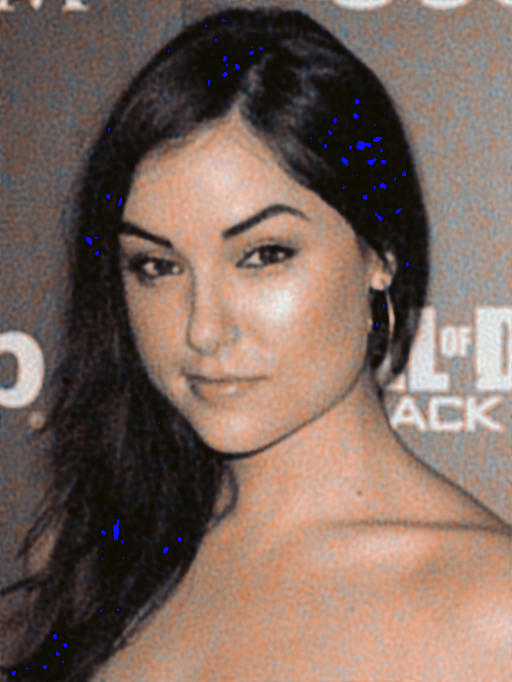

In [ ]:
step_i = 0

while True:
    pred_image = uber_inet(uvs)
    pred_image = pred_image.permute(2,0,1)
    loss = F.mse_loss(pred_image, image)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    wandb.log({
        'loss': loss.item(),
        'step': step_i
    })
        
    
    if (step_i%steps_til_vis == 0):
        wandb.log({'image': wandb.Image(tensor2pil(pred_image)), 'step': step_i})
    
    if (step_i%steps_til_summary==0):
        clear_output()
        print(f'step_i={step_i} {loss.item():.4f}')
        display(pred_image.rgb)
        
    step_i += 1